In [8]:
from nifti import NiftiImage
import numpy as np
from scipy import stats
import pylab
# from http://stackoverflow.com/questions/3579568/choosing-a-file-in-python-with-simple-dialog
from Tkinter import Tk
from tkFileDialog import askopenfilename

Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
filename = askopenfilename() # show an "Open" dialog box and return the path to the selected file
print(filename)

/home/sophie/Desktop/100051ss1_1000regcUmKFMNyqcentral.nii


In [9]:
nim=NiftiImage(filename)

In [10]:
D=nim.data

In [11]:
D.shape

(11573, 9, 23, 44)

In [75]:
from thunder.rdds.fileio.imagesloader import ImagesLoader
imgs = ImagesLoader(sc).fromArrays(list(D))

In [76]:
imgs.dims

Dimensions(values=[(0, 0, 0), (8, 22, 43)], n=3)

In [78]:
Ser=imgs.toSeries()

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
sns.set_style('darkgrid')
from thunder import Colorize
image = Colorize.image

In [16]:
#P=prctile(reshape(R,size(R,1)*size(R,2),1),90);
#R1=double(R).*(10000/P);

In [17]:
#demean

In [18]:
#%%Smith lines
#[uu,ss,vv]=nets_svds(R,30); % initial SVD to the top 30 components (arbitrary number fixed in MELODIC)
#vv(abs(vv)<2.3*std(vv(:)))=0;  % zero small values in PCA maps  %what is that doing here?
#stddevs=max(std(R-uu*ss*vv'),0.1);  % subtract main parts of top components from data to get normalisation
#R=R./repmat(stddevs,size(R,1),1);  % var-norm

In [19]:
#[u,s,v]=nets_svds(R,Npc);

In [20]:
#[icasig, A, W] = fastica (v','approach','symm','epsilon', 0.000001);

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

from sklearn.decomposition import FastICA, PCA

#see http://scikit-learn.org/stable/auto_examples/decomposition/plot_ica_blind_source_separation.html

In [22]:
from thunder import ICA
model = ICA(k=50,c=50).fit(Ser)

In [29]:
icamaps = model.sigs.pack()
icamaps.shape # dimensions should be (k, x, y, z) where k is the number of components

(50, 9, 23, 44)

In [56]:
DT=model.a/np.sqrt(np.var(model.a))

In [57]:
data=icamaps.T/np.sqrt(np.var(icamaps.T))

In [58]:
S=data.shape

In [59]:
Demean=data
Dvar=data
Var=np.zeros(S[3])
Tvar=np.zeros(S[3])
Sk=np.zeros(S[3])
Kr=np.zeros(S[3])

In [60]:
for i in range(S[3]):
    Demean[:,:,:,i]=data[:,:,:,i]-np.mean(np.mean(data[:,:,:,i],0),0)

In [61]:
for i in range(S[2]):
    Dsq=np.reshape(Demean[:,:,:,i],S[0]*S[1]*S[2])
    Var[i]=np.var(Dsq)
    Dvar[:,:,:,i]=Demean[:,:,:,i]/Var[i]
    Kr[i]=stats.kurtosis(Dsq)
    Sk[i]=stats.skew(Dsq)

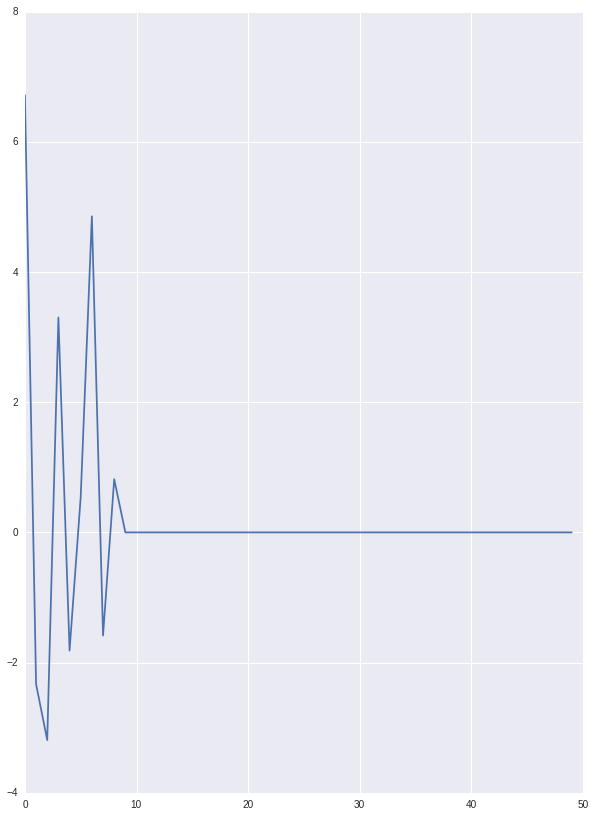

In [62]:
plt.plot(Sk)

In [63]:
Percs=np.percentile(range(S[2]),[20,40,60,80,100])
Indices=np.split(range(S[2]),Percs)
D1=data[:,:,range(5),2]
Dmean=data[:,:,range(5),2]
Dmaps=np.zeros([S[0],S[1],5,S[3]])

In [64]:
for i in range(5):
    Vmean=np.mean(Dvar[:,:,Indices[i],:],3)
    Dmean[:,:,i]=np.max(Vmean,2)

In [65]:
my_cmap=plt.cm.jet
my_cmap.set_bad(alpha=0)

Good_ICs=np.zeros(S[3])

In [66]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 2000;

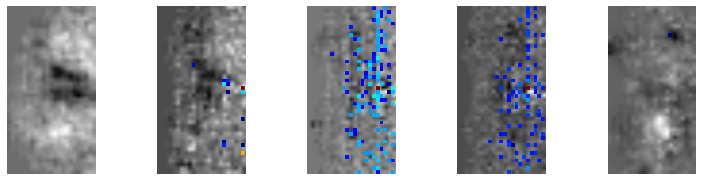

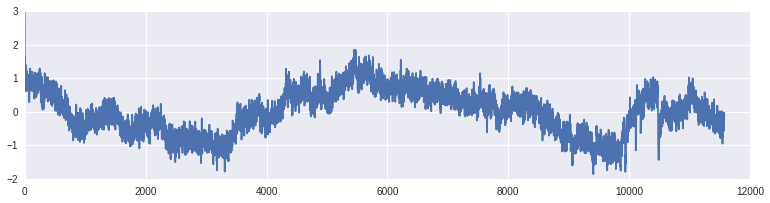

0


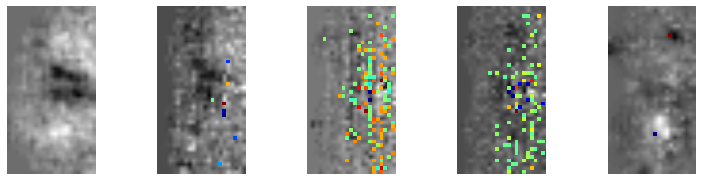

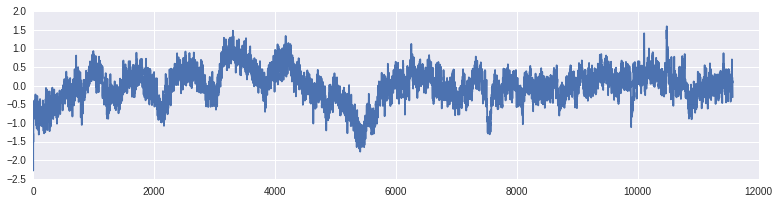

0


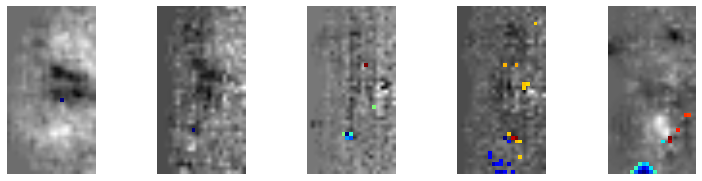

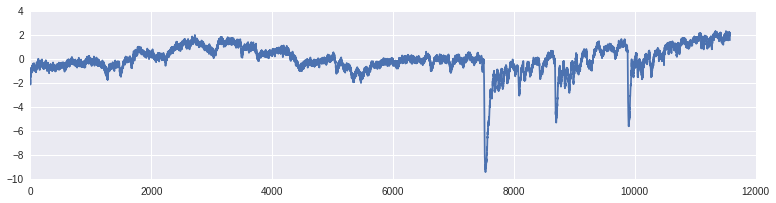

1


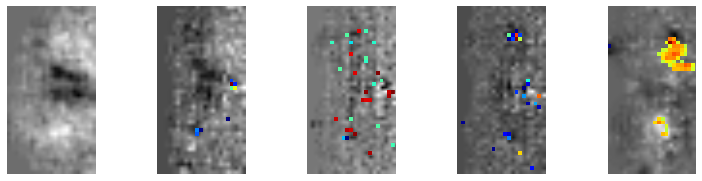

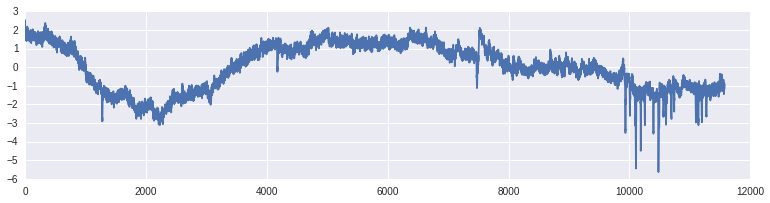

0


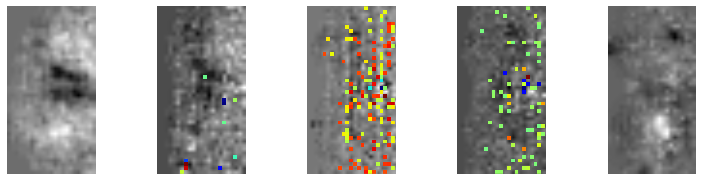

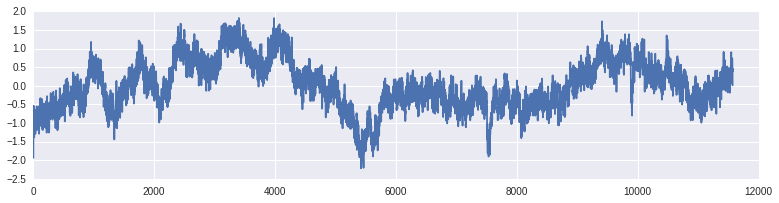

0


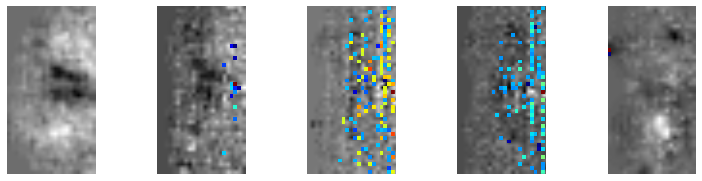

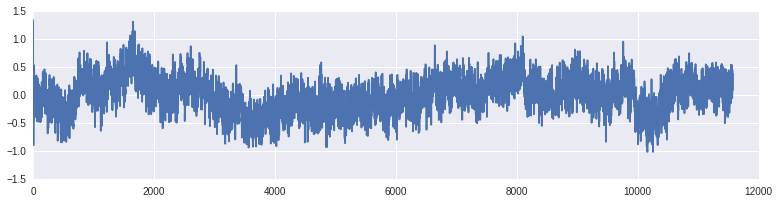

0


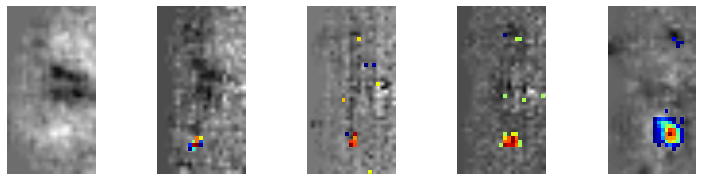

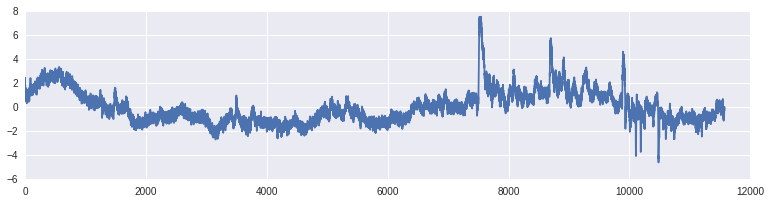

1


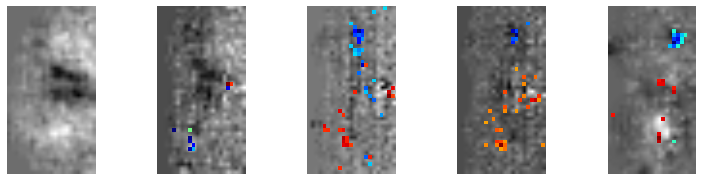

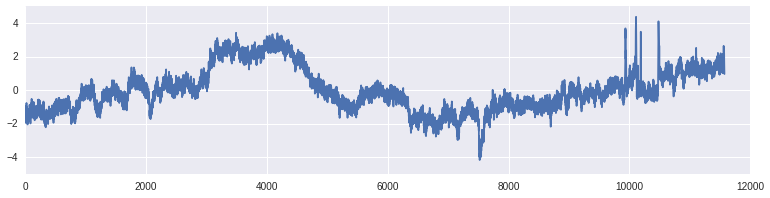

0


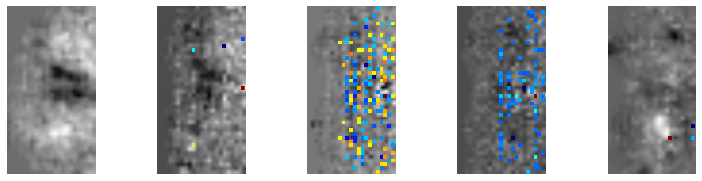

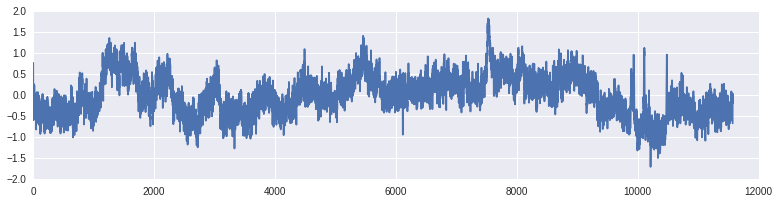

0


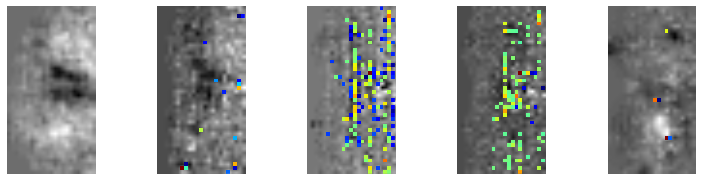

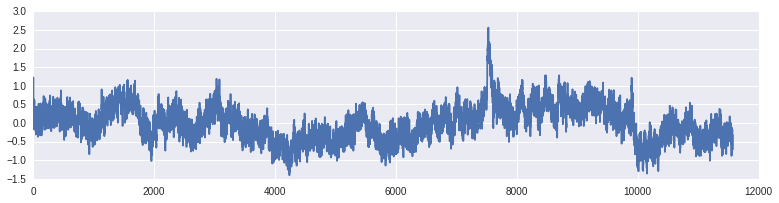

1


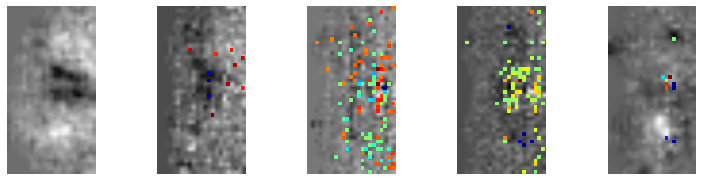

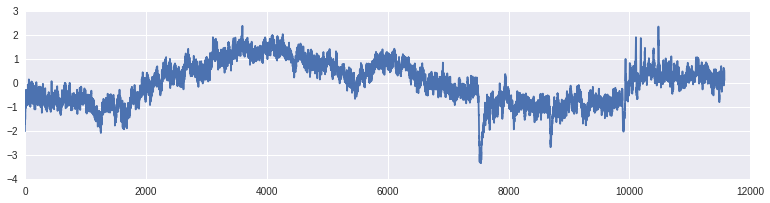

1


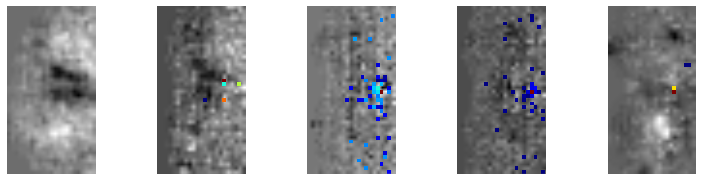

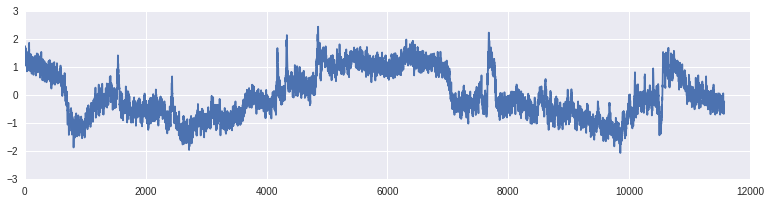

1


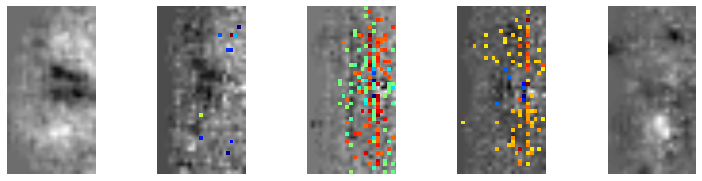

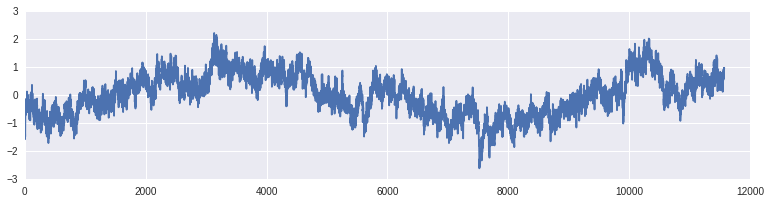

1


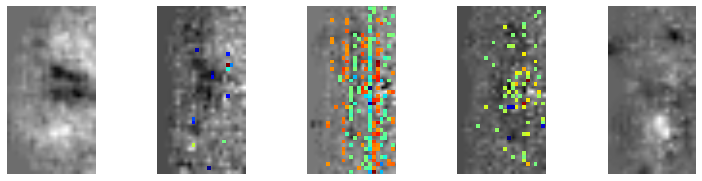

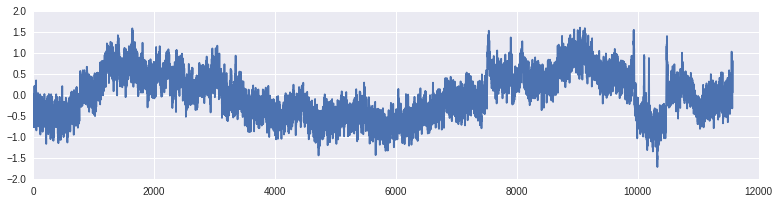

0


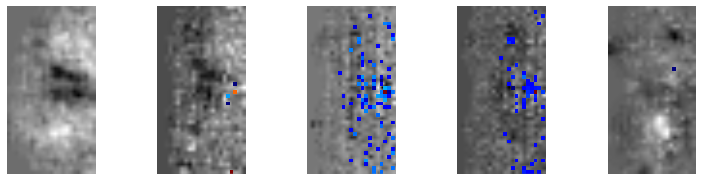

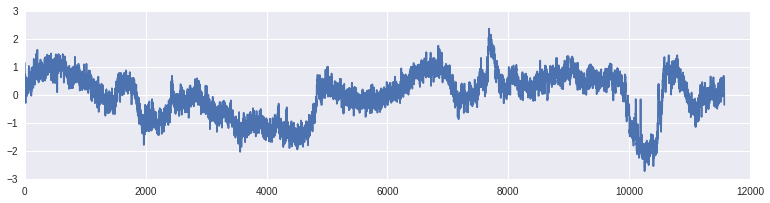

1


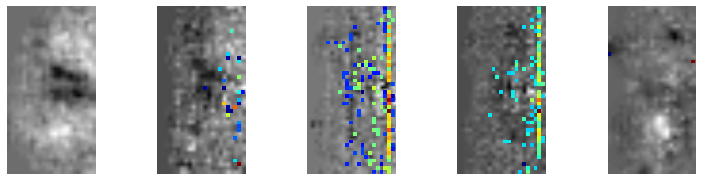

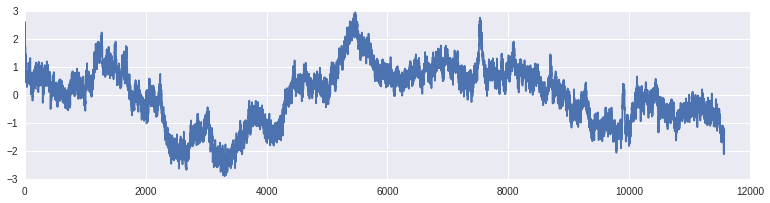

0


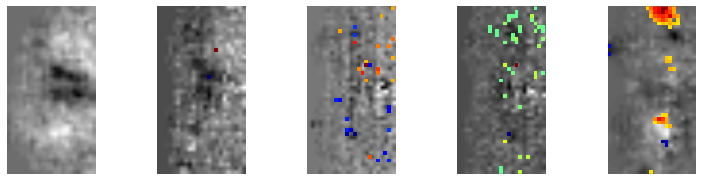

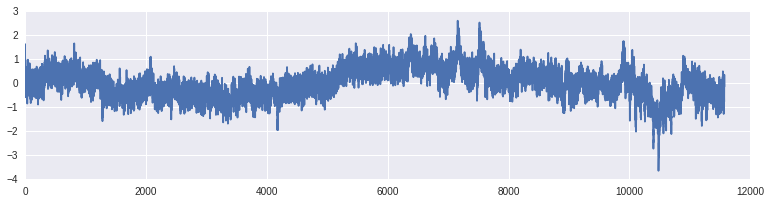

1


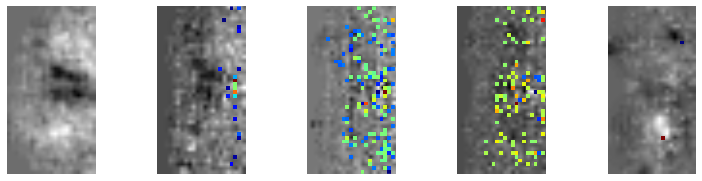

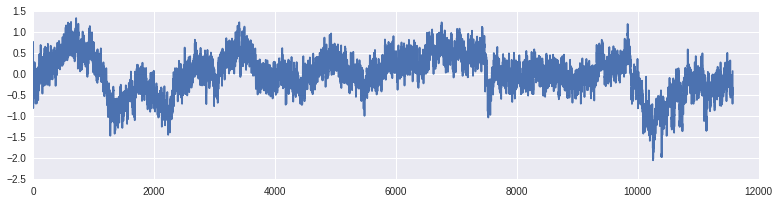

0


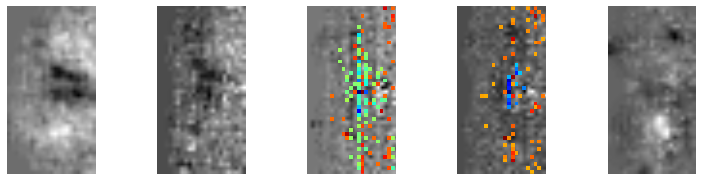

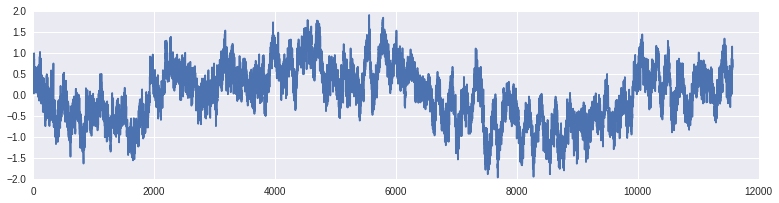

1


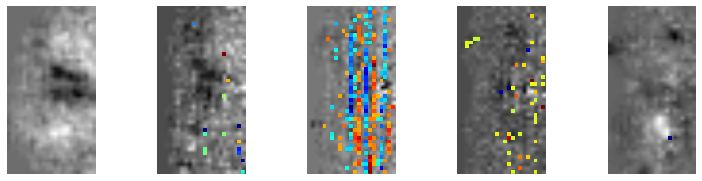

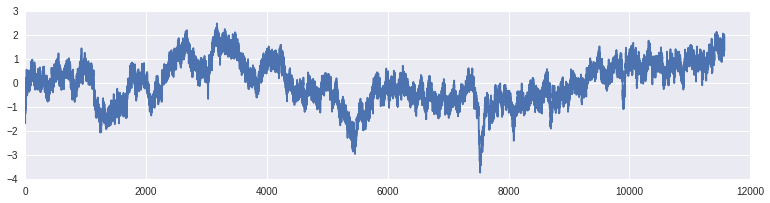

0


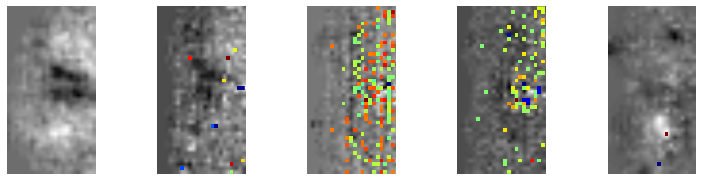

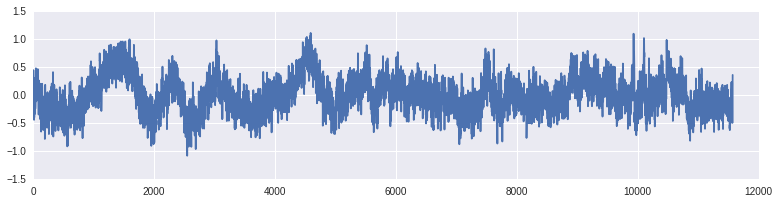

0


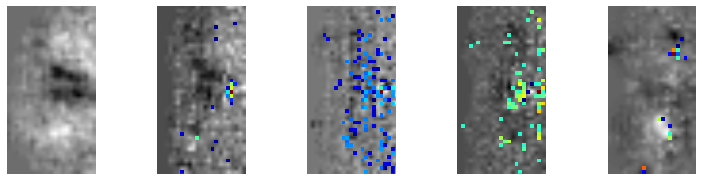

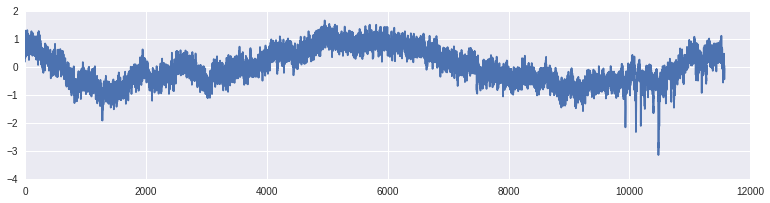

0


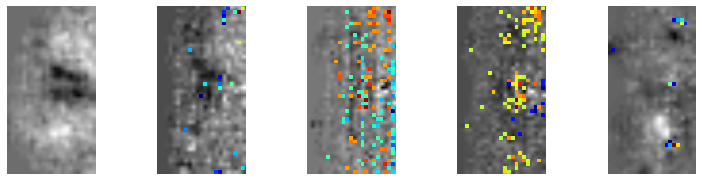

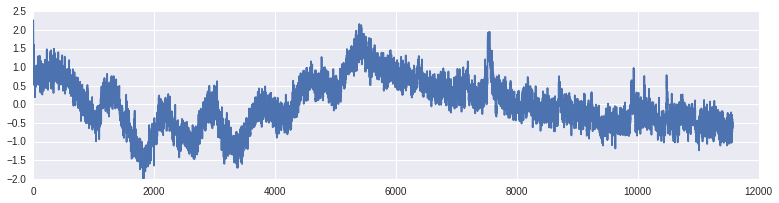

0


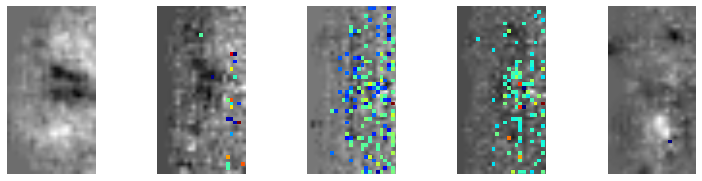

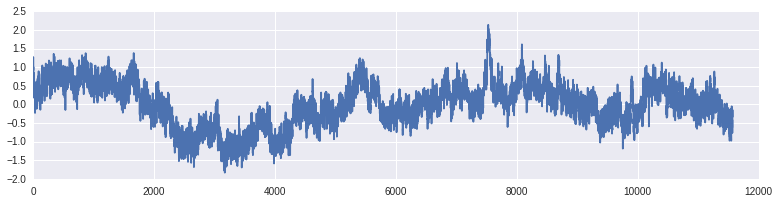

0


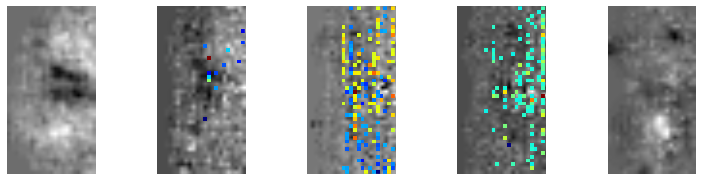

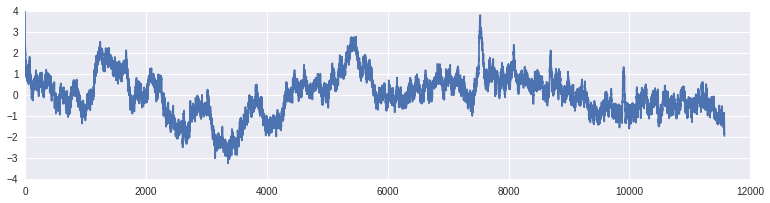

1


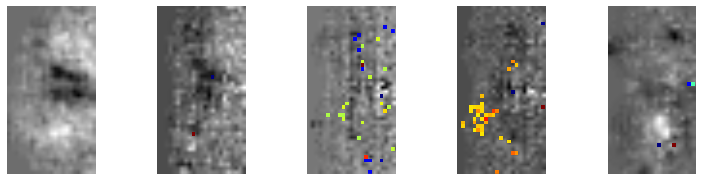

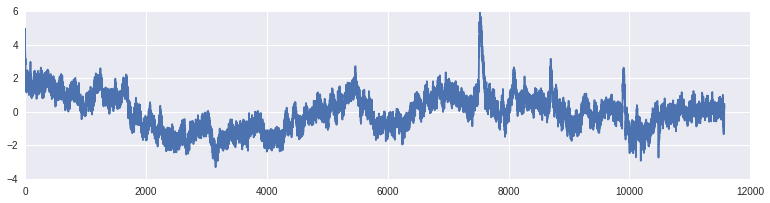

1


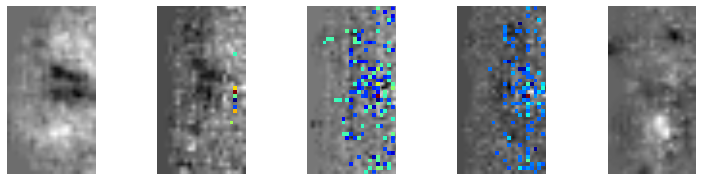

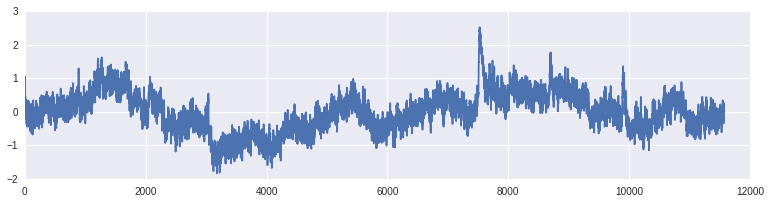

1


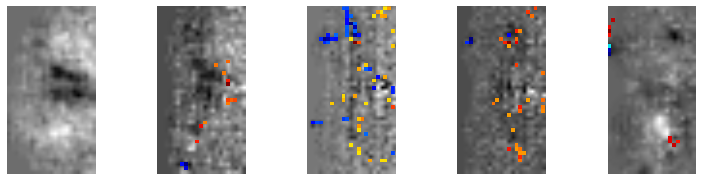

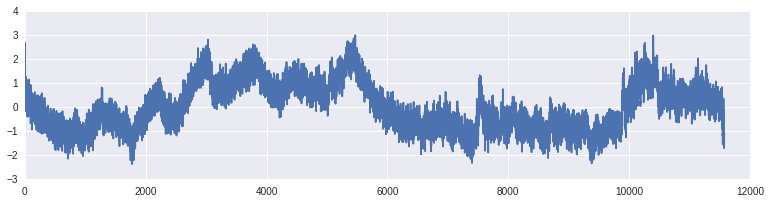

0


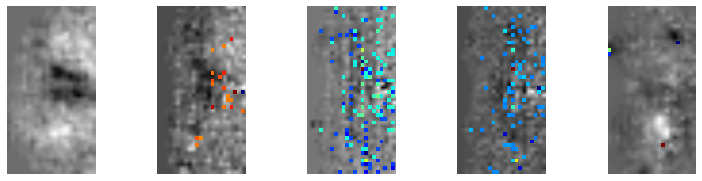

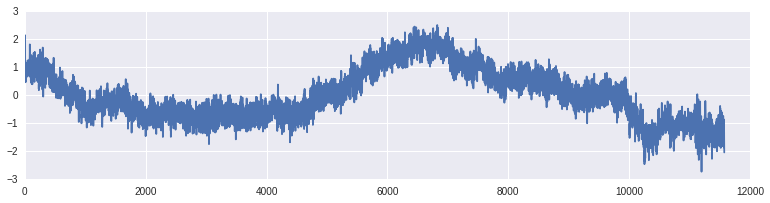

0


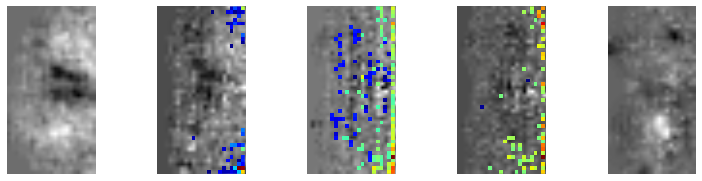

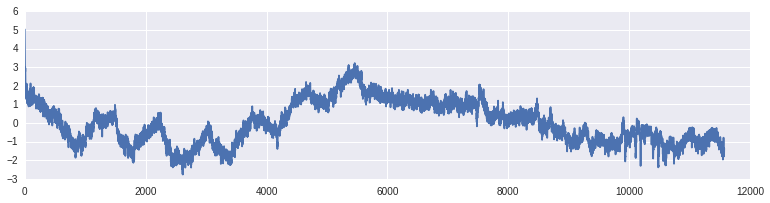

0


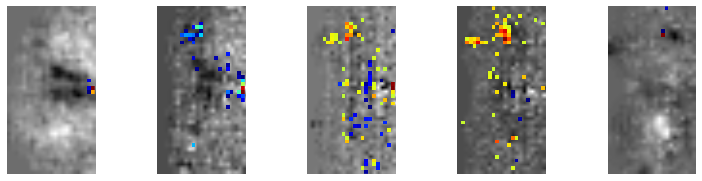

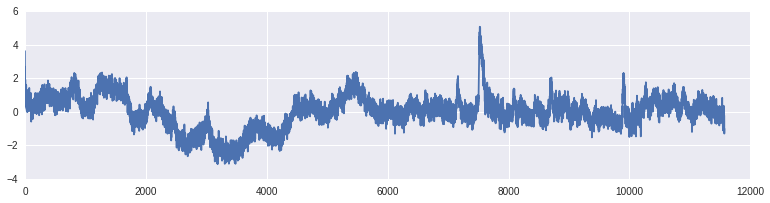

1


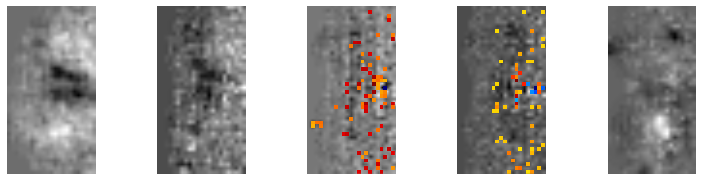

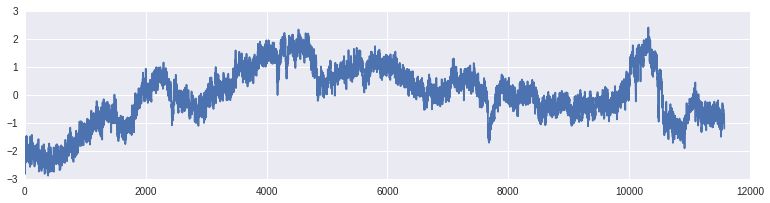

0


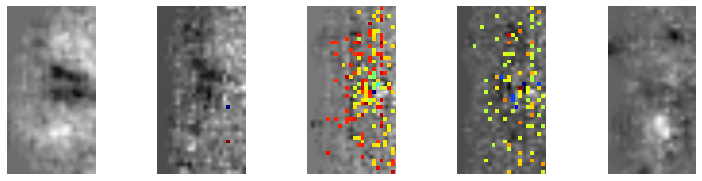

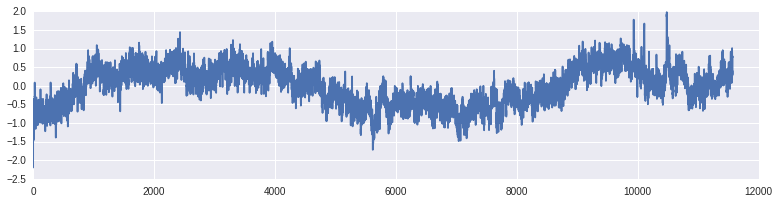

0


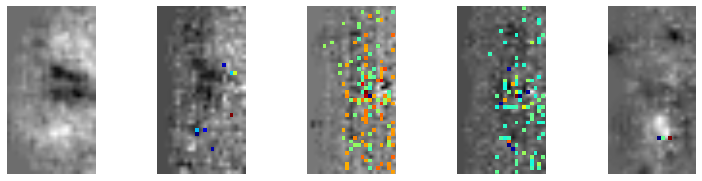

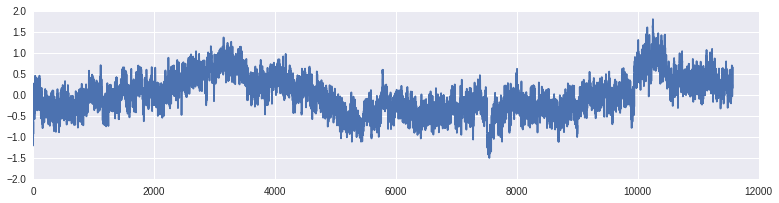

0


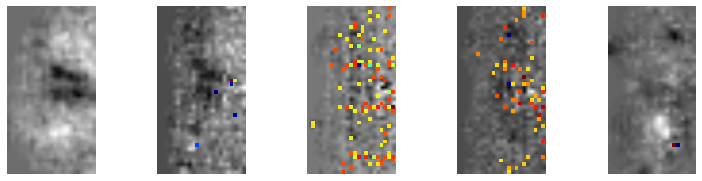

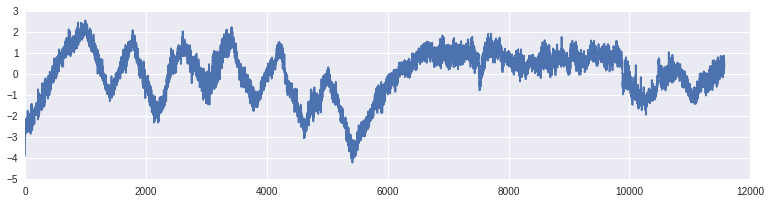

0


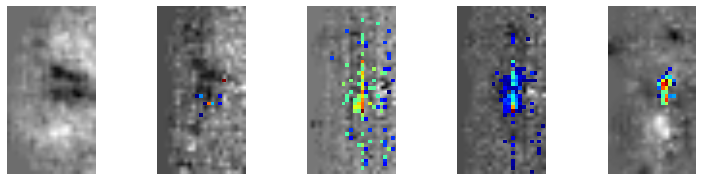

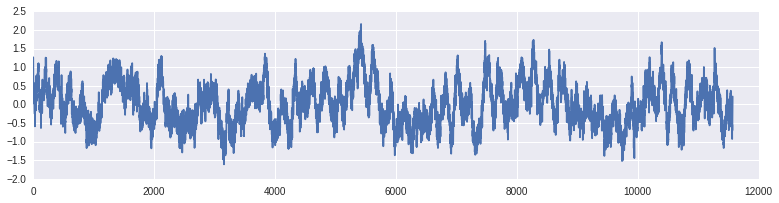

1


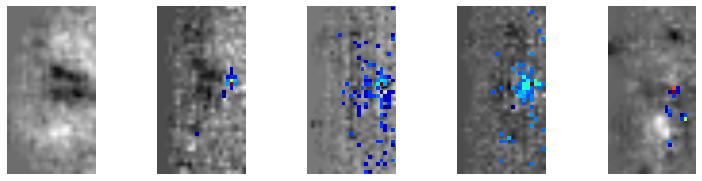

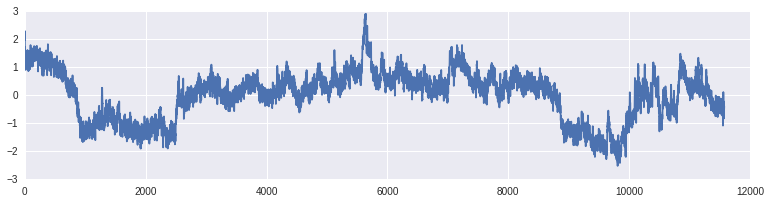

1


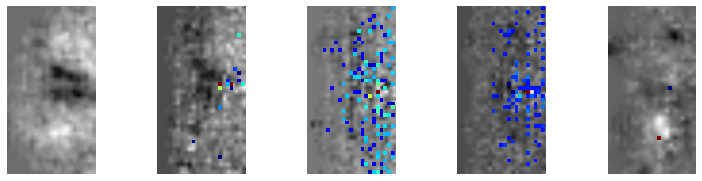

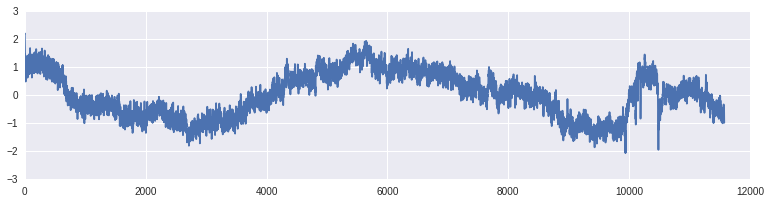

0


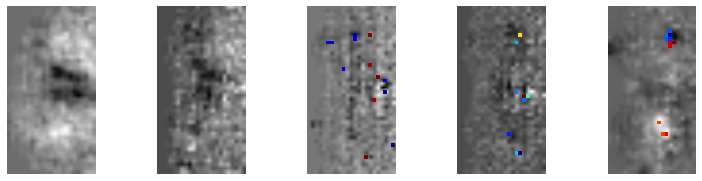

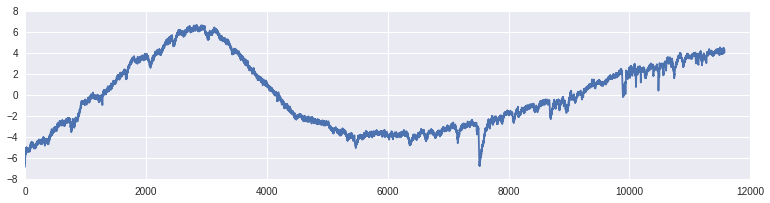

0


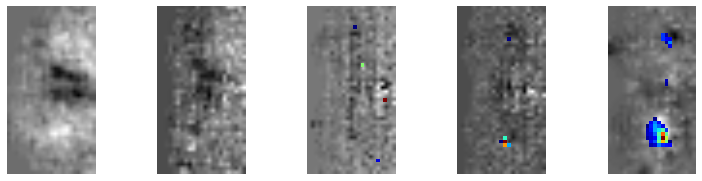

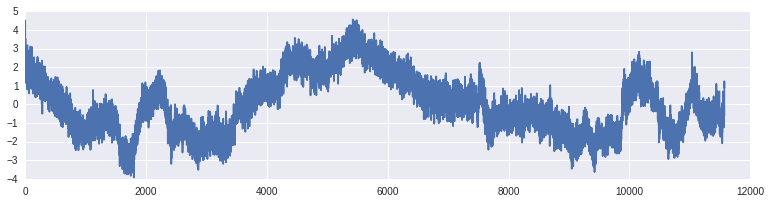

1


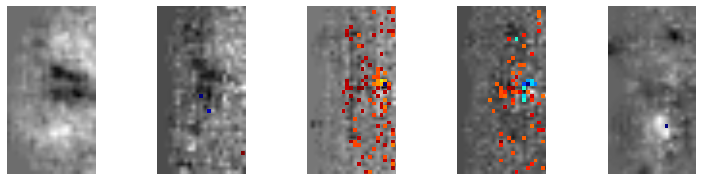

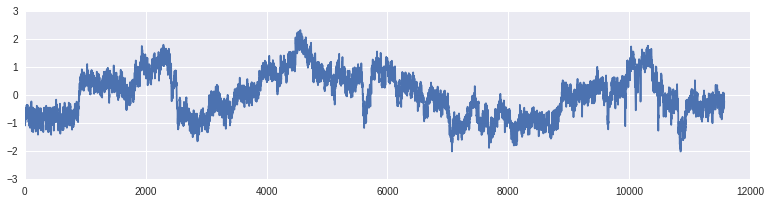

1


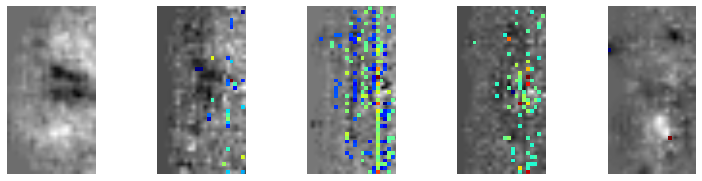

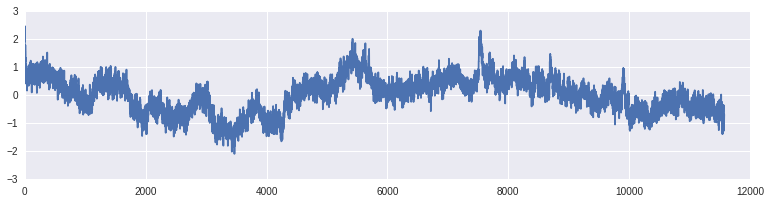

1


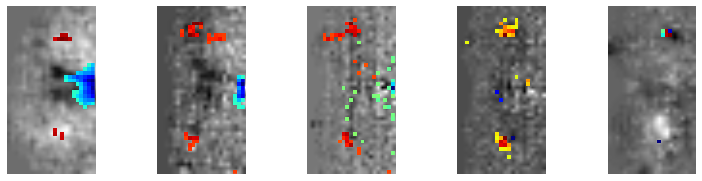

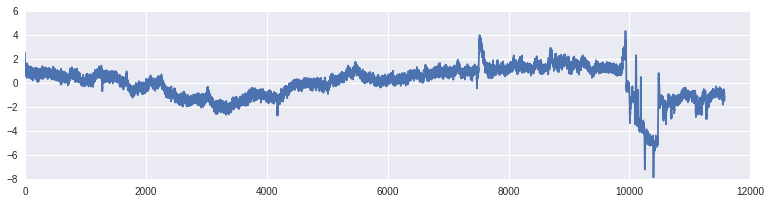

0


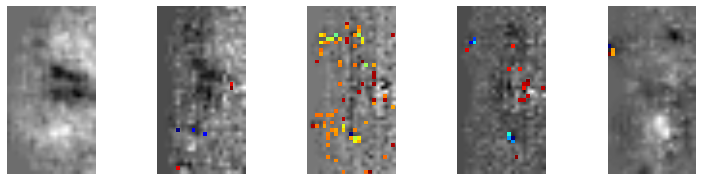

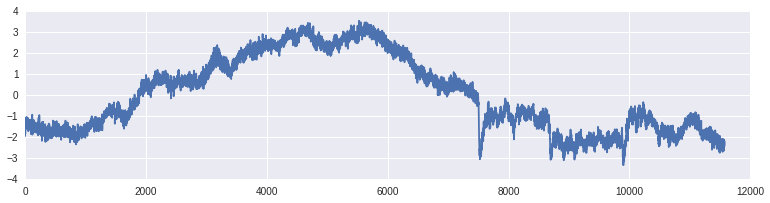

0


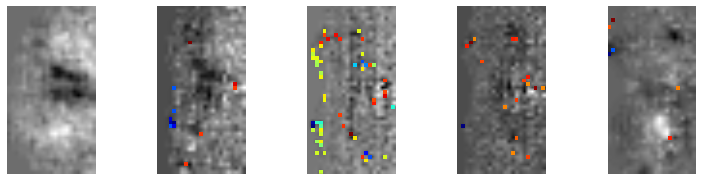

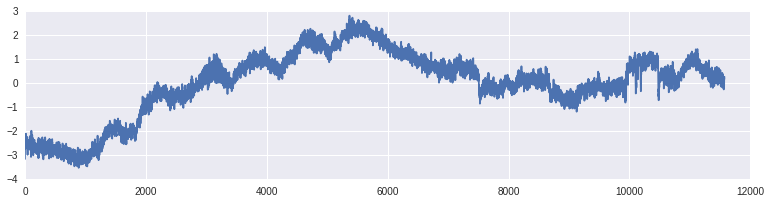

0


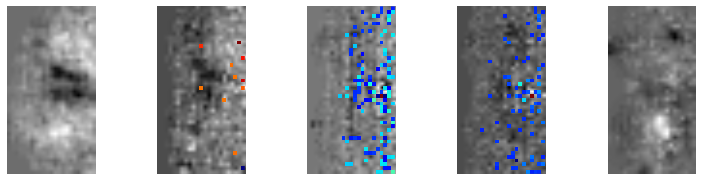

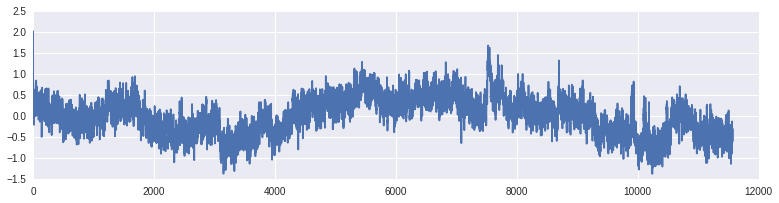

0


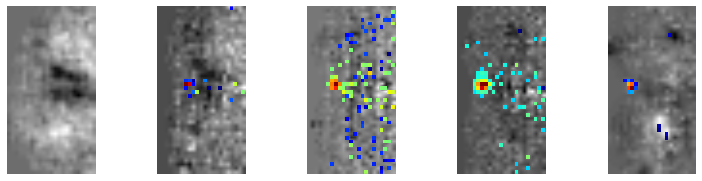

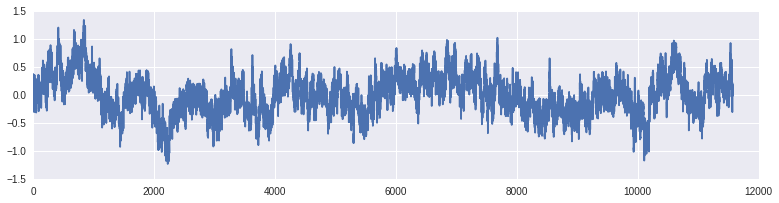

1


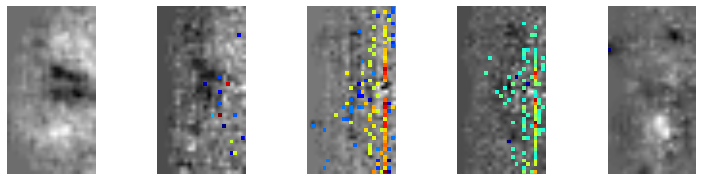

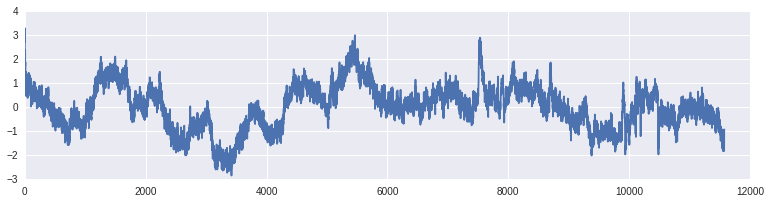

0


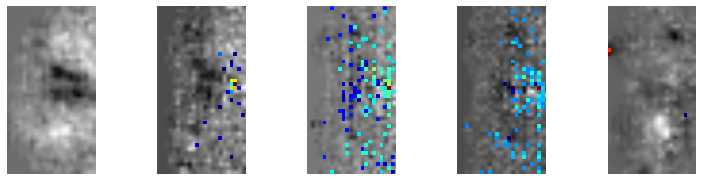

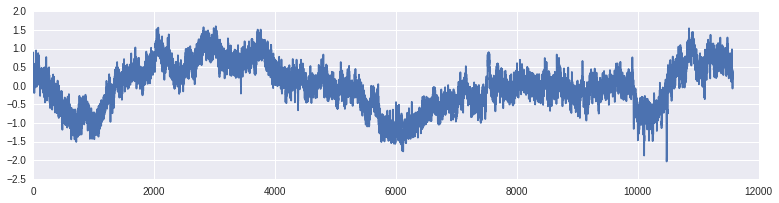

0


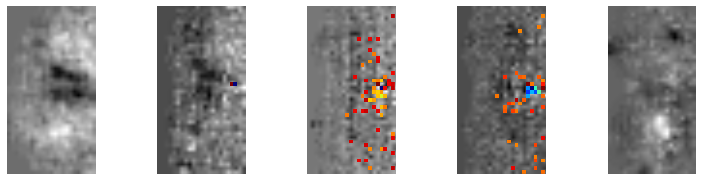

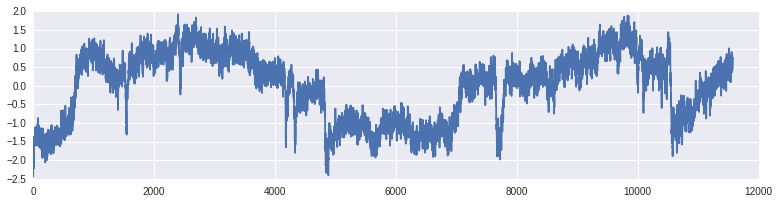

1


In [67]:
pylab.rcParams['figure.figsize'] = (13, 3)

for j in range(S[3]):
    
    for i in range(5):
        V=Dvar[:,:,Indices[i],j]
        D1[:,:,i]=np.max(V,2)
        
    D1[np.abs(D1)<2.3]=np.nan
    
    for i in range(5):
        plt.subplot(1,5,i+1)
        plt.imshow(Dmean[:,:,i],cmap=plt.cm.gray)
        plt.imshow(D1[:,:,i], cmap=my_cmap,interpolation='none')
        frame1 = plt.gca()
        frame1.axes.get_xaxis().set_visible(False)
        frame1.axes.get_yaxis().set_visible(False)
        
    plt.show()
    
    plt.plot(DT.T[j])
    plt.show()
    Good_ICs[j]=input()
    
    Dmaps[:,:,:,j]=np.abs(D1)-2.30

In [68]:
where_are_NaNs = np.isnan(Dmaps)

Dmaps[where_are_NaNs] = 0

In [69]:
Final_map=np.zeros([S[0],S[1],5,3])
Fmaps=np.zeros([S[0],S[1],5,3])
C=np.zeros([S[3],3])

In [70]:
for j in range(S[3]):
    
    if Good_ICs[j]:
        C[j,:]=np.squeeze(np.random.rand(3,1))
        for k in range(3):
            M=np.max(np.squeeze(np.reshape(Dmaps[:,:,:,j],S[0]*S[1]*5)))
            #M[M==0]=1
  #          Fmaps[:,:,:,k]=0.7*Dmaps[:,:,:,j]*C[j,k]/np.max(np.squeeze(np.reshape(Dmaps[:,:,:,j]*np.max(C[j,:],S[0]*S[1]*5))
            Fmaps[:,:,:,k]=0.7*Dmaps[:,:,:,j]*C[j,k]/(M*np.max(C[j,:]))
        Final_map=Final_map+Fmaps

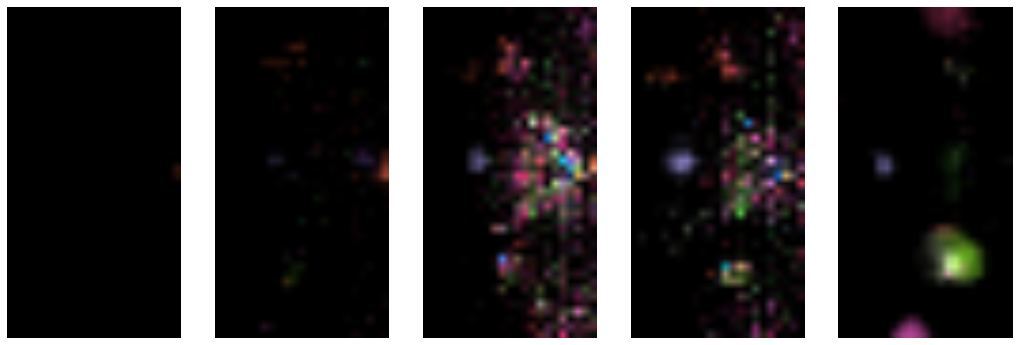

In [71]:
pylab.rcParams['figure.figsize'] = (18, 14)
for i in range(5):
        plt.subplot(1,5,i+1)
        plt.imshow(Final_map[:,:,i]) 
        frame1 = plt.gca()
        frame1.axes.get_xaxis().set_visible(False)
        frame1.axes.get_yaxis().set_visible(False)

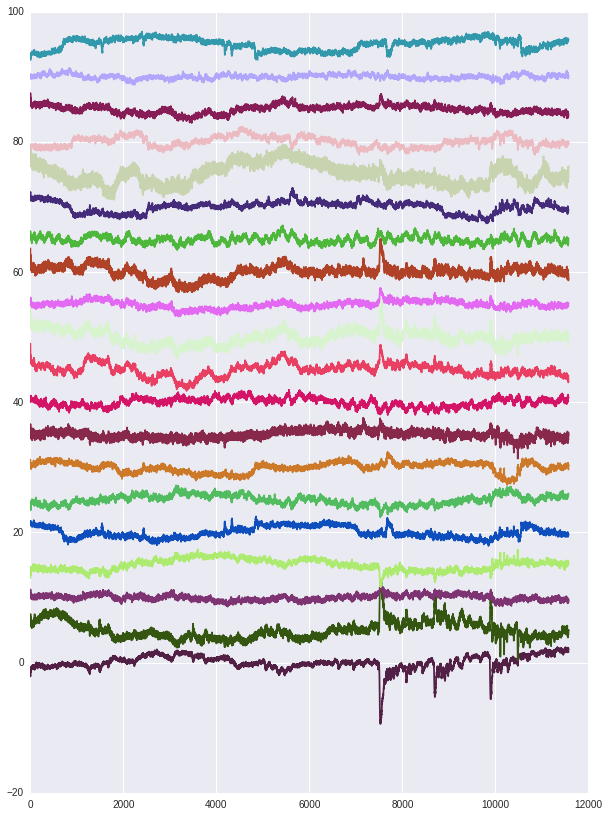

In [72]:
pylab.rcParams['figure.figsize'] = (10, 14)
h=5
i=0

for j in range(S[3]):
    if Good_ICs[j]:
        plt.plot((DT[:,j]+h*i),color=C[j,:])
        i=i+1

plt.show()

# NMF

In [ ]:
imgs.min().min()

In [73]:
from thunder import NMF
model2 = NMF(k=50,maxIter=20).fit(S)

Exception: Input must be Series or a subclass (e.g. RowMatrix)